In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,classification_report,precision_score,roc_auc_score,matthews_corrcoef,precision_recall_fscore_support,make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn import model_selection

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.combine import SMOTEENN 
 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,StackingClassifier,VotingClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [102]:
df=pd.read_excel("C:/Users/saich/OneDrive/Desktop/Diabetes_Classification.xlsx")

In [103]:
df.drop(labels="Patient number",axis=1,inplace=True)

In [104]:
df.replace({'Gender':{"female":"F","male":"M"}},inplace=True)

In [105]:
le=LabelEncoder()
df["Gender"]=le.fit_transform(df["Gender"])

In [106]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Cholesterol        50.000
Glucose            26.750
HDL Chol           21.000
Chol/HDL ratio      2.200
Age                26.000
Gender              1.000
Height              6.000
Weight             49.750
BMI                 8.175
Systolic BP        26.000
Diastolic BP       15.000
waist               8.000
hip                 7.000
Waist/hip ratio     0.100
dtype: float64


In [107]:
df=df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [108]:
target=df["Diabetes"]
features=df.drop(columns="Diabetes",axis=1)

In [109]:
sm = SMOTEENN(random_state=42,sampling_strategy="minority") 
new_features, new_target = sm.fit_resample(features, target)

In [110]:
scaler = StandardScaler()
X_res=pd.DataFrame(scaler.fit_transform(new_features),columns=list(new_features.columns))
y_res=new_target

In [111]:
y_res.value_counts()

Diabetes       272
No diabetes    219
Name: Diabetes, dtype: int64

In [112]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,Y_train1,Y_test1=train_test_split(X_res,
                                               y_res,
                                               test_size=0.35,
                                               random_state=42)

# Function to get scores(KFold cross validation)

In [113]:
def evaluate_model_accuracy(model, X, y):
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)
    return scores


def evaluate_model_recall_positive(model,X,y):
    scoring = {'recall' : make_scorer(recall_score,pos_label="Diabetes") }
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    results =cross_validate(estimator=model,
                                    X=X,
                                    y=y,
                                    cv=kfold,
                                    scoring=scoring)
    return results["test_recall"]

def evaluate_model_recall_negative(model,X,y):
    scoring = {'recall' : make_scorer(recall_score,pos_label="No diabetes") }
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    results =cross_validate(estimator=model,
                                    X=X,
                                    y=y,
                                    cv=kfold,
                                    scoring=scoring)
    return results["test_recall"]

def evaluate_model_roc_auc(model, X, y):
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
    return scores

def evaluate_model_matthews_corrcoef(model,X,y):
    score=matthews_corrcoef(y,model.predict(X))
    return score

def evaluate_model_precision(model,X,y):
    scoring = {'precision' : make_scorer(recall_score,pos_label="Diabetes") }
    kfold = model_selection.KFold(n_splits=25, random_state=42, shuffle=True)
    results =cross_validate(estimator=model,
                                    X=X,
                                    y=y,
                                    cv=kfold,
                                    scoring=scoring)
    return results["test_precision"]

def evaluate_model_f1score(model,X,y):
    scoring = {'f1' : make_scorer(recall_score,pos_label="Diabetes") }
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    results =cross_validate(estimator=model,
                                    X=X,
                                    y=y,
                                    cv=kfold,
                                    scoring=scoring)
    return results["test_f1"]


# Logistic Regression

In [114]:
LR=LogisticRegression(C=11.288378916846883,penalty="l2",solver= 'liblinear')

LR.fit(X_train1,Y_train1)

LogisticRegression(C=11.288378916846883, solver='liblinear')

In [115]:
print(classification_report(Y_test1,LR.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.87      0.90      0.89        94
 No diabetes       0.88      0.83      0.86        78

    accuracy                           0.87       172
   macro avg       0.87      0.87      0.87       172
weighted avg       0.87      0.87      0.87       172



In [116]:
cv = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
scoring = {'recall' : make_scorer(recall_score,pos_label="Diabetes") }

In [117]:
# for recall
results1 =cross_validate(estimator=LR,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring=scoring)
# for accuracy
accuracy1 = model_selection.cross_val_score(LR, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [118]:
print("Accuracy",np.mean(accuracy1))
print("recall score is :",np.mean(results1["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(LR, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results1["score_time"]))
print("fit time is :",np.mean(results1["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=LR,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.8561491935483871
recall score is : 0.8951401174504889
roc-auc score is 0.9053583453583454
score time is : 0.002134227752685547
fit time is : 0.0054665088653564455
recall score for No diabetes is : 0.8109249084249084


# Grid Search

In [119]:
# # # # param_grid = [
# # # #     {
# # # #      'penalty' : ['l1', 'l2'],
# # # #     'C' : np.logspace(-4, 4, 20),
# # # #     'solver' : ['liblinear']}
# # # # ]

# # # param_grid = [
# # #     {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
# # # ]

# param_grid = dict(n_neighbors=list(range(10, 31)))

# # grid = RandomizedSearchCV(knn, param_distributions = param_grid, cv = 10,n_jobs=-1)
# grid=GridSearchCV(knn,param_grid,cv=5,n_jobs=-1)

In [120]:
# grid.fit(X_train1,Y_train1)

In [121]:
# grid.best_params_

# Decsison Trees

In [122]:
classifier1=DecisionTreeClassifier(criterion="entropy",max_depth=6)

In [123]:
classifier1.fit(X_train1,Y_train1)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [124]:
print(classification_report(Y_test1,classifier1.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.93      0.98      0.95        94
 No diabetes       0.97      0.91      0.94        78

    accuracy                           0.95       172
   macro avg       0.95      0.94      0.95       172
weighted avg       0.95      0.95      0.95       172



In [125]:
results2 =cross_validate(estimator=classifier1,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy2 = model_selection.cross_val_score(classifier1, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [126]:
print("Accuracy",np.mean(accuracy2))
print("recall score is :",np.mean(results1["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(classifier1, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results1["score_time"]))
print("fit time is :",np.mean(results1["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=classifier1,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=model_selection.KFold(n_splits=10),
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.946875
recall score is : 0.8951401174504889
roc-auc score is 0.9583333333333334
score time is : 0.002134227752685547
fit time is : 0.0054665088653564455
recall score for No diabetes is : 0.9365709773318469


# KNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier  
knn= KNeighborsClassifier(n_neighbors=11,n_jobs=-1)  
knn.fit(X_train1, Y_train1) 

KNeighborsClassifier(n_jobs=-1, n_neighbors=11)

In [128]:
print(classification_report(Y_test1,knn.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.80      1.00      0.89        94
 No diabetes       1.00      0.71      0.83        78

    accuracy                           0.87       172
   macro avg       0.90      0.85      0.86       172
weighted avg       0.89      0.87      0.86       172



In [129]:
results3 =cross_validate(estimator=knn,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy3 = model_selection.cross_val_score(knn, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [130]:
print("Accuracy",np.mean(accuracy3))
print("recall score for Diabetes is :",np.mean(results3["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(knn, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results3["score_time"]))
print("fit time is :",np.mean(results3["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=knn,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.8936491935483872
recall score for Diabetes is : 1.0
roc-auc score is 0.9496574875741542
score time is : 0.020770549774169922
fit time is : 0.002905535697937012
recall score for No diabetes is : 0.7785897435897435


# Naive bayes

In [131]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train1, Y_train1)

GaussianNB()

In [132]:
print(classification_report(Y_test1,nb.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.91      0.82      0.86        94
 No diabetes       0.80      0.90      0.85        78

    accuracy                           0.85       172
   macro avg       0.86      0.86      0.85       172
weighted avg       0.86      0.85      0.85       172



In [133]:
results4 =cross_validate(estimator=nb,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy4 = model_selection.cross_val_score(nb, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [134]:
print("Accuracy",np.mean(accuracy4))
print("recall score is :",np.mean(results4["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(nb, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results4["score_time"]))
print("fit time is :",np.mean(results4["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=nb,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=model_selection.KFold(n_splits=10),
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.8872983870967742
recall score is : 0.8613055309843235
roc-auc score is 0.9446657046657047
score time is : 0.004675149917602539
fit time is : 0.0
recall score for No diabetes is : 0.9047765700483092


# SVM

In [135]:
svm = SVC(kernel='rbf',probability=True)
svm.fit(X_train1, Y_train1)

SVC(probability=True)

In [136]:
print(classification_report(Y_test1,svm.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.95      1.00      0.97        94
 No diabetes       1.00      0.94      0.97        78

    accuracy                           0.97       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172



In [137]:
results5 =cross_validate(estimator=svm,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy5 = model_selection.cross_val_score(svm, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [138]:
print("Accuracy",np.mean(accuracy5))
print("recall score is :",np.mean(results5["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(svm, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results5["score_time"]))
print("fit time is :",np.mean(results5["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=svm,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.98125
recall score is : 0.9944444444444445
roc-auc score is 0.9902076318742985
score time is : 0.0030948877334594726
fit time is : 0.04593820571899414
recall score for No diabetes is : 0.9667658730158729


# Random Forests

In [139]:
rf=RandomForestClassifier()
rf.fit(X_train1, Y_train1)

RandomForestClassifier()

In [140]:
print(classification_report(Y_test1,rf.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.98      1.00      0.99        94
 No diabetes       1.00      0.97      0.99        78

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172



In [141]:
results6 =cross_validate(estimator=rf,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy6 = model_selection.cross_val_score(rf, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [142]:
print("Accuracy",np.mean(accuracy6))
print("recall score is :",np.mean(results6["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(rf, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results6["score_time"]))
print("fit time is :",np.mean(results6["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=rf,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=model_selection.KFold(n_splits=10),
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.9875
recall score is : 1.0
roc-auc score is 0.9957070707070708
score time is : 0.01731414794921875
fit time is : 0.23004500865936278
recall score for No diabetes is : 0.9658342623560016


# Ensembel

In [143]:
model1= VotingClassifier(estimators=[ ('dt', classifier1),('knn',knn),('svm',svm),('nb',nb),('LR',LR)], voting='soft')
model1.fit(X_train1,Y_train1)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=6)),
                             ('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=11)),
                             ('svm', SVC(probability=True)),
                             ('nb', GaussianNB()),
                             ('LR',
                              LogisticRegression(C=11.288378916846883,
                                                 solver='liblinear'))],
                 voting='soft')

In [144]:
print(classification_report(Y_test1,model1.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.95      1.00      0.97        94
 No diabetes       1.00      0.94      0.97        78

    accuracy                           0.97       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172



In [145]:
results =cross_validate(estimator=model1,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring=scoring)
accuracy = model_selection.cross_val_score(LR, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [146]:
print("Accuracy",np.mean(accuracy))
print("recall score is :",np.mean(results["test_recall"]))
print("score time is :",np.mean(results["score_time"]))
print("fit time is :",np.mean(results["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=model1,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.8561491935483871
recall score is : 0.9817460317460318
score time is : 0.03000314235687256
fit time is : 0.03623464107513428
recall score for No diabetes is : 0.9418452380952381


# Ensemble of classifier,svm

In [147]:
model2= VotingClassifier(estimators=[ ('dt', classifier1),('svm',svm)], voting='soft')
model2.fit(X_train1,Y_train1)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=6)),
                             ('svm', SVC(probability=True))],
                 voting='soft')

# Ensemble of rf,etc

In [148]:
model3= VotingClassifier(estimators=[ ('rf', rf),('etc',etc)], voting='soft')
model3.fit(X_train1,Y_train1)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('etc',
                              ExtraTreesClassifier(n_estimators=60,
                                                   random_state=42))],
                 voting='soft')

# Ensemble of logistic regression classifiers.

In [149]:
logbagClf = BaggingClassifier(LR, n_estimators = 15,random_state=8)
logbagClf.fit(X_train1, Y_train1)

BaggingClassifier(base_estimator=LogisticRegression(C=11.288378916846883,
                                                    solver='liblinear'),
                  n_estimators=15, random_state=8)

In [150]:
print(classification_report(Y_test1,logbagClf.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.85      0.91      0.88        94
 No diabetes       0.89      0.81      0.85        78

    accuracy                           0.87       172
   macro avg       0.87      0.86      0.86       172
weighted avg       0.87      0.87      0.87       172



In [151]:
print('Accuracy: %.3f ' % (np.mean(model_selection.cross_val_score(logbagClf, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1))*100))

Accuracy: 87.177 


In [152]:
print("recall score is :",np.mean(cross_validate(estimator=LR,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring=scoring)["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(logbagClf, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=logbagClf,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))


recall score is : 0.8951401174504889
roc-auc score is 0.8974851691518358
recall score for No diabetes is : 0.8420955433455433


In [153]:
print("accuracy is: ",np.mean(evaluate_model_accuracy(rf,X_res,y_res)))
print("diabetes recall is: ",np.mean(evaluate_model_recall_positive(rf,X_res,y_res)))
print("no diabetes recall is: ",np.mean(evaluate_model_recall_negative(rf,X_res,y_res)))
print("roc_auc is: ",np.mean(evaluate_model_roc_auc(rf,X_res,y_res)))
print("matthews_corrcoef is: ",evaluate_model_matthews_corrcoef(rf,X_res,y_res))

accuracy is:  0.9898367346938775
diabetes recall is:  1.0
no diabetes recall is:  0.9752443648305718
roc_auc is:  0.9998333333333334
matthews_corrcoef is:  0.991783731383183


# Gradient boost

In [154]:
Gboost= GradientBoostingClassifier(learning_rate=0.9,random_state=42)
Gboost.fit(X_train1, Y_train1)

GradientBoostingClassifier(learning_rate=0.9, random_state=42)

# Adaboost

In [155]:
Adaboost = AdaBoostClassifier(random_state=42)
Adaboost.fit(X_train1, Y_train1)

AdaBoostClassifier(random_state=42)

# Confusion Matrix

In [156]:
def conf_matrix(y_true,x_true,model):
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_true, model.predict(x_true)), annot=True)
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Diabetes', 'No Diabetes']); ax.yaxis.set_ticklabels(['Diabetes', 'No Diabetes']);
    return ax

# testing scores

In [157]:
print("accuracy is: ",np.mean(evaluate_model_accuracy(nb,X_test1,Y_test1)))
print("diabetes recall is: ",np.mean(evaluate_model_recall_positive(nb,X_test1,Y_test1)))
print("no diabetes recall is: ",np.mean(evaluate_model_recall_negative(nb,X_test1,Y_test1)))
print("roc_auc is: ",np.mean(evaluate_model_roc_auc(nb,X_test1,Y_test1)))
print("matthews_corrcoef is: ",evaluate_model_matthews_corrcoef(nb,X_test1,Y_test1))
print("Precision is: ",np.mean(evaluate_model_precision(nb,X_test1,Y_test1)))

accuracy is:  0.8715686274509803
diabetes recall is:  0.8645959595959596
no diabetes recall is:  0.8930555555555554
roc_auc is:  0.9446657046657047
matthews_corrcoef is:  0.7135259149750443
Precision is:  0.8686666666666667


# ExtraTreesClassifier

In [158]:
etc = ExtraTreesClassifier(n_estimators=60,random_state=42)
etc.fit(X_train1,Y_train1)

ExtraTreesClassifier(n_estimators=60, random_state=42)

In [159]:
print("accuracy is: ",np.mean(evaluate_model_accuracy(etc,X_test1,Y_test1)))
print("diabetes recall is: ",np.mean(evaluate_model_recall_positive(etc,X_test1,Y_test1)))
print("no diabetes recall is: ",np.mean(evaluate_model_recall_negative(etc,X_test1,Y_test1)))
print("roc_auc is: ",np.mean(evaluate_model_roc_auc(etc,X_test1,Y_test1)))
print("matthews_corrcoef is: ",evaluate_model_matthews_corrcoef(etc,X_test1,Y_test1))
print("Precision is: ",np.mean(evaluate_model_precision(etc,X_test1,Y_test1)))

accuracy is:  0.965032679738562
diabetes recall is:  1.0
no diabetes recall is:  0.9194444444444445
roc_auc is:  0.9986111111111111
matthews_corrcoef is:  0.9767598625352237
Precision is:  1.0


# showing Confusion matrix

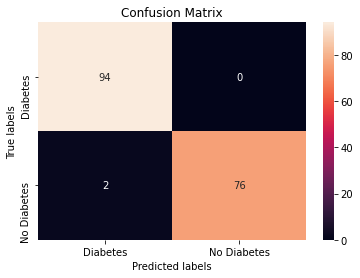

In [160]:
conf_matrix(Y_test1,X_test1,etc)
plt.show()

# Total scores

In [161]:
scores_df=pd.DataFrame()

LR_scores={'accuracy': [0.8868421052631579],
 'recall_positive': [0.9058658008658009],

 'roc_auc': [0.9233404928404928],
 'precision': [0.9058658008658009],
 "f1_score":[0.9058658008658009]}

scores_df=pd.DataFrame(LR_scores,index=["LR"])

scores_df.loc["knn"] = [np.mean(evaluate_model_accuracy(knn,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(knn,X_test1,Y_test1)),
               
                       np.mean(evaluate_model_roc_auc(knn,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(knn,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(knn,X_test1,Y_test1))]


scores_df.loc["classifier1"] = [np.mean(evaluate_model_accuracy(classifier1,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(classifier1,X_test1,Y_test1)),
                 
                       np.mean(evaluate_model_roc_auc(classifier1,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(classifier1,X_test1,Y_test1)),
                               np.mean(evaluate_model_f1score(classifier1,X_test1,Y_test1))]

scores_df.loc["svm"] = [np.mean(evaluate_model_accuracy(svm,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(svm,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(svm,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(svm,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(svm,X_test1,Y_test1))]

scores_df.loc["nb"] = [np.mean(evaluate_model_accuracy(nb,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(nb,X_test1,Y_test1)),
                  
                       np.mean(evaluate_model_roc_auc(nb,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(nb,X_test1,Y_test1)),
                      np.mean(evaluate_model_f1score(nb,X_test1,Y_test1))]

scores_df.loc["rf"] = [np.mean(evaluate_model_accuracy(rf,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(rf,X_test1,Y_test1)),
                
                       np.mean(evaluate_model_roc_auc(rf,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(rf,X_test1,Y_test1)),
                      np.mean(evaluate_model_f1score(rf,X_test1,Y_test1))]

scores_df.loc["Gboost"] = [np.mean(evaluate_model_accuracy(Gboost,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(Gboost,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(Gboost,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(Gboost,X_test1,Y_test1)),
                          np.mean(evaluate_model_f1score(Gboost,X_test1,Y_test1))]

scores_df.loc["Adaboost"] = [np.mean(evaluate_model_accuracy(Adaboost,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(Adaboost,X_test1,Y_test1)),
                  
                       np.mean(evaluate_model_roc_auc(Adaboost,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(Adaboost,X_test1,Y_test1)),
                            np.mean(evaluate_model_f1score(Adaboost,X_test1,Y_test1))]

scores_df.loc["etc"] = [np.mean(evaluate_model_accuracy(etc,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(etc,X_test1,Y_test1)),
                     
                       np.mean(evaluate_model_roc_auc(etc,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(etc,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(etc,X_test1,Y_test1))]

scores_df.loc["model1"] = [np.mean(evaluate_model_accuracy(model1,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model1,X_test1,Y_test1)),
                     
                       np.mean(evaluate_model_roc_auc(model1,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model1,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model1,X_test1,Y_test1))]

scores_df.loc["model2"] = [np.mean(evaluate_model_accuracy(model2,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model2,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model2,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model2,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model2,X_test1,Y_test1))]

scores_df.loc["LR"] = [np.mean(evaluate_model_accuracy(LR,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(LR,X_test1,Y_test1)),
               
                       np.mean(evaluate_model_roc_auc(LR,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(LR,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(LR,X_test1,Y_test1))]

scores_df.loc["model3"] = [np.mean(evaluate_model_accuracy(model3,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model3,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model3,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model3,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model3,X_test1,Y_test1))]

In [162]:
scores_df["total_scores"] = scores_df.sum(axis=1)

scores_df

,accuracy,recall_positive,roc_auc,precision,f1_score,total_scores
LR,0.860131,0.894394,0.905358,0.895333,0.894394,4.449610
knn,0.889216,0.935707,0.949657,0.933333,0.935707,4.643621
classifier1,0.947059,1.000000,0.935972,0.972000,0.988889,4.843920
svm,0.947386,0.967298,0.990208,0.973333,0.967298,4.845523
nb,0.871569,0.864596,0.944666,0.868667,0.864596,4.414093
rf,0.976471,1.000000,0.995909,0.990000,0.988889,4.951269
Gboost,0.952941,0.988889,0.987500,0.990000,0.988889,4.908219
Adaboost,0.912092,0.926187,0.940152,0.958667,0.926187,4.663283
etc,0.965033,1.000000,0.998611,1.000000,1.000000,4.963644
model1,0.923856,0.935707,0.984217,0.933333,0.935707,4.712821


In [163]:
scores_df.sort_values(by="recall_positive",ascending=False)

,accuracy,recall_positive,roc_auc,precision,f1_score,total_scores
classifier1,0.947059,1.000000,0.935972,0.972000,0.988889,4.843920
rf,0.976471,1.000000,0.995909,0.990000,0.988889,4.951269
etc,0.965033,1.000000,0.998611,1.000000,1.000000,4.963644
model2,0.958824,1.000000,0.995455,0.968667,1.000000,4.922945
model3,0.976471,1.000000,0.998611,1.000000,1.000000,4.975082
Gboost,0.952941,0.988889,0.987500,0.990000,0.988889,4.908219
svm,0.947386,0.967298,0.990208,0.973333,0.967298,4.845523
knn,0.889216,0.935707,0.949657,0.933333,0.935707,4.643621
model1,0.923856,0.935707,0.984217,0.933333,0.935707,4.712821
Adaboost,0.912092,0.926187,0.940152,0.958667,0.926187,4.663283


# Individual Scores

In [164]:
individual_scores=pd.DataFrame()

LR_scores={'accuracy': [0.8868421052631579],
 'recall_positive': [0.9058658008658009],

 'roc_auc': [0.9233404928404928],
 'precision': [0.9058658008658009],
 "f1_score":[0.9058658008658009]}

individual_scores=pd.DataFrame(LR_scores,index=["LR"])

individual_scores.loc["knn"] = [np.mean(evaluate_model_accuracy(knn,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(knn,X_test1,Y_test1)),
               
                       np.mean(evaluate_model_roc_auc(knn,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(knn,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(knn,X_test1,Y_test1))]


individual_scores.loc["classifier1"] = [np.mean(evaluate_model_accuracy(classifier1,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(classifier1,X_test1,Y_test1)),
                 
                       np.mean(evaluate_model_roc_auc(classifier1,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(classifier1,X_test1,Y_test1)),
                               np.mean(evaluate_model_f1score(classifier1,X_test1,Y_test1))]

individual_scores.loc["svm"] = [np.mean(evaluate_model_accuracy(svm,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(svm,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(svm,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(svm,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(svm,X_test1,Y_test1))]

individual_scores.loc["nb"] = [np.mean(evaluate_model_accuracy(nb,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(nb,X_test1,Y_test1)),
                  
                       np.mean(evaluate_model_roc_auc(nb,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(nb,X_test1,Y_test1)),
                      np.mean(evaluate_model_f1score(nb,X_test1,Y_test1))]

# Ensemble Models Scores

In [165]:
Ensemble_scores=pd.DataFrame()

rf_scores={'accuracy': [0.9642105263157894],
 'recall_positive': [0.9818181818181818],

 'roc_auc': [0.9944971694971695],
 'precision': [0.9584415584415584],
 "f1_score":[0.9825757575757577]}

Ensemble_scores=pd.DataFrame(rf_scores,index=["rf"])


Ensemble_scores.loc["Gboost"] = [np.mean(evaluate_model_accuracy(Gboost,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(Gboost,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(Gboost,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(Gboost,X_test1,Y_test1)),
                          np.mean(evaluate_model_f1score(Gboost,X_test1,Y_test1))]

Ensemble_scores.loc["Adaboost"] = [np.mean(evaluate_model_accuracy(Adaboost,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(Adaboost,X_test1,Y_test1)),
                  
                       np.mean(evaluate_model_roc_auc(Adaboost,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(Adaboost,X_test1,Y_test1)),
                            np.mean(evaluate_model_f1score(Adaboost,X_test1,Y_test1))]

Ensemble_scores.loc["etc"] = [np.mean(evaluate_model_accuracy(etc,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(etc,X_test1,Y_test1)),
                     
                       np.mean(evaluate_model_roc_auc(etc,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(etc,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(etc,X_test1,Y_test1))]

Ensemble_scores.loc["rf"] = [np.mean(evaluate_model_accuracy(rf,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(rf,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(rf,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(rf,X_test1,Y_test1)),
                          np.mean(evaluate_model_f1score(rf,X_test1,Y_test1))]


In [166]:
custom_custom_ensemble_scores=pd.DataFrame()

model1_scores={'accuracy': [0.9021052631578949],
 'recall_positive': [ 0.9058658008658009],

 'roc_auc': [0.9726289266289267],
 'precision': [0.9058658008658009],
 "f1_score":[ 0.9058658008658009]}

custom_ensemble_scores=pd.DataFrame(model1_scores,index=["model1"])


custom_ensemble_scores.loc["model2"] = [np.mean(evaluate_model_accuracy(model2,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model2,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model2,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model2,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model2,X_test1,Y_test1))]

custom_ensemble_scores.loc["model1"] = [np.mean(evaluate_model_accuracy(model1,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model1,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model1,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model1,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model1,X_test1,Y_test1))]

custom_ensemble_scores.loc["model3"] = [np.mean(evaluate_model_accuracy(model3,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model3,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model3,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model3,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model3,X_test1,Y_test1))]

In [167]:
individual_scores.sort_values(by='recall_positive',ascending=False)

,accuracy,recall_positive,roc_auc,precision,f1_score
classifier1,0.941503,0.990000,0.947778,0.972000,0.990000
svm,0.947386,0.967298,0.990208,0.973333,0.967298
knn,0.889216,0.935707,0.949657,0.933333,0.935707
LR,0.886842,0.905866,0.923340,0.905866,0.905866
nb,0.871569,0.864596,0.944666,0.868667,0.864596


In [168]:
Ensemble_scores.sort_values(by='recall_positive',ascending=False)

,accuracy,recall_positive,roc_auc,precision,f1_score
rf,0.976471,1.000000,0.997096,0.970000,1.000000
etc,0.965033,1.000000,0.998611,1.000000,1.000000
Gboost,0.952941,0.988889,0.987500,0.990000,0.988889
Adaboost,0.912092,0.926187,0.940152,0.958667,0.926187


In [169]:
custom_ensemble_scores

,accuracy,recall_positive,roc_auc,precision,f1_score
model1,0.923856,0.935707,0.987149,0.920,0.925707
model2,0.958824,1.000000,0.995455,0.992,0.990000
model3,0.976471,1.000000,0.998611,1.000,1.000000


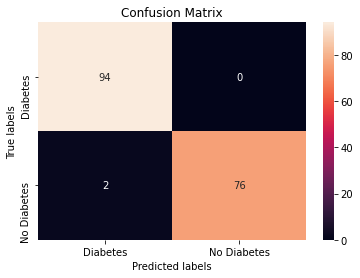

In [175]:
conf_matrix(Y_test1,X_test1,rf)
plt.show()

In [171]:
Y_test1.value_counts()

Diabetes       94
No diabetes    78
Name: Diabetes, dtype: int64